### Step 1: Setup and Data Collection

In [1]:
# Install required packages
# pip install streamlit yfinance pandas matplotlib

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import pandas_datareader
import datetime
import pandas_datareader.data as web
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 2. Data Collection & Preparation

Use the Yahoo Finance API or any other reliable financial data source to gather historical daily stock price data for the selected stocks: Microsoft, Amazon, Google, Tesla, Dell, and Apple.
Retrieve the stock price data for a specific time range that aligns with the desired analysis period.

In [119]:
# Generate Mock Market Data
def generate_mock_market_data(start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    returns = np.random.normal(0.0005, 0.01, len(date_range))  # Random daily returns with mean 0.0005 and standard deviation 0.01
    market_data = pd.DataFrame({'Adj Close': (1 + returns).cumprod()}, index=date_range)
    return market_data

In [126]:
market_data = generate_mock_market_data(start_date, end_date)

In [128]:
market_data.head()

,Adj Close
2020-01-01,1.007226
2020-01-02,1.026865
2020-01-03,1.026017
2020-01-04,1.016531
2020-01-05,1.028293


#### 2.1 Collection Historical Stock Data

In [94]:
# Step 1.1: Collect Historical Stock Price Data
def get_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return stock_data

# Selected stocks and time range for data collection
selected_stocks = ['MSFT', 'AMZN', 'GOOGL', 'TSLA', 'DELL', 'AAPL']
start_date = '2020-01-01'
end_date = '2023-01-01'

# Fetch historical stock price data
stock_data = get_stock_data(selected_stocks, start_date, end_date)

[*********************100%***********************]  6 of 6 completed


In [95]:
#checking the first five records in the dataset
stock_data.head()

,AAPL,AMZN,DELL,GOOGL,MSFT,TSLA
Date,,,,,,
2020-01-02,73.347939,94.900497,25.437757,68.433998,155.422058,28.684000
2020-01-03,72.634834,93.748497,24.601021,68.075996,153.486755,29.534000
2020-01-06,73.213623,95.143997,24.849123,69.890503,153.883545,30.102667
2020-01-07,72.869293,95.343002,24.226437,69.755501,152.480438,31.270666
2020-01-08,74.041496,94.598503,24.323729,70.251999,154.909195,32.809334


In [96]:
#checking the last five records in the dataset
stock_data.tail()

,AAPL,AMZN,DELL,GOOGL,MSFT,TSLA
Date,,,,,,
2022-12-23,131.477127,85.250000,38.472378,89.230003,237.614105,123.150002
2022-12-27,129.652435,83.040001,38.757580,87.389999,235.852386,109.099998
2022-12-28,125.674026,81.820000,38.118340,86.019997,233.433731,112.709999
2022-12-29,129.233658,84.180000,39.160793,88.449997,239.883453,121.820000
2022-12-30,129.552719,84.000000,39.554173,88.230003,238.699020,123.180000


In [97]:
# Checking the number rows and records
stock_data.shape

(756, 6)

In [98]:
# Checking the data summary
stock_data.describe()

,AAPL,AMZN,DELL,GOOGL,MSFT,TSLA
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,128.910999,142.455482,39.576925,104.257655,241.644998,206.365502
std,30.726050,27.856019,10.843333,26.472870,47.908623,95.856975
min,54.923035,81.820000,14.044520,52.706501,131.395462,24.081333
25%,113.837992,118.337875,32.157181,78.220125,207.211609,138.270828
50%,134.342514,154.467499,41.493462,104.272999,242.658905,223.651665
75%,149.705551,164.633247,48.300842,126.982876,279.866753,276.565002
max,180.434280,186.570496,58.327915,149.838501,338.335968,409.970001


#### 2.2: Calculate Daily Returns and Relevant Metrics

In [99]:
# Step 1.2: Calculate Daily Returns and Relevant Metrics
def calculate_daily_returns(stock_data):
    return stock_data.pct_change().dropna()

# Calculate daily returns
daily_returns = calculate_daily_returns(stock_data)

In [100]:
daily_returns.head()

,AAPL,AMZN,DELL,GOOGL,MSFT,TSLA
Date,,,,,,
2020-01-03,-0.009722,-0.012139,-0.032893,-0.005231,-0.012452,0.029633
2020-01-06,0.007968,0.014886,0.010085,0.026654,0.002585,0.019255
2020-01-07,-0.004703,0.002092,-0.025059,-0.001932,-0.009118,0.038801
2020-01-08,0.016086,-0.007809,0.004016,0.007118,0.015928,0.049205
2020-01-09,0.021241,0.004799,-0.007600,0.010498,0.012493,-0.021945


#### 2.3: Prepare Macroeconomic Data

In [101]:
# In this assignment, dummy macroeconomic data will be generated for illustration purposes.
# In a real-world scenario, these data would need to fetch actual macroeconomic data from reliable sources like the world bank.
def create_dummy_macroeconomic_data(start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    dummy_data = pd.DataFrame({
        'Interest_Rate': [0.02] * len(date_range),  # Constant interest rate for illustration
        'Inflation_Rate': [0.015] * len(date_range),  # Constant inflation rate for illustration
        'GDP_Growth_Rate': [0.03] * len(date_range),  # Constant GDP growth rate for illustration
        'Government_Policy': ['Stable'] * len(date_range),  # Constant government policy for illustration
    }, index=date_range)
    return dummy_data

# Create dummy macroeconomic data for the same time range as stock data
macroeconomic_data = create_dummy_macroeconomic_data(start_date, end_date)

In [102]:
macroeconomic_data.head()

,Interest_Rate,Inflation_Rate,GDP_Growth_Rate,Government_Policy
2020-01-01,0.02,0.015,0.03,Stable
2020-01-02,0.02,0.015,0.03,Stable
2020-01-03,0.02,0.015,0.03,Stable
2020-01-04,0.02,0.015,0.03,Stable
2020-01-05,0.02,0.015,0.03,Stable


### 3. Portfolio Evolution

In [104]:
# Given asset allocation percentages
allocation_percentages = {
    'MSFT': 0.20,
    'AMZN': 0.15,
    'GOOGL': 0.18,
    'TSLA': 0.20,
    'DELL': 0.12,
    'AAPL': 0.15,
}

In [105]:
# Calculate the total portfolio value based on the historical stock data
total_portfolio_value = stock_data.iloc[-1]  # Last row of stock data represents the latest stock prices
total_portfolio_value = total_portfolio_value.dot([allocation_percentages[symbol] for symbol in selected_stocks])

In [106]:
# Calculate the allocation amount for each stock based on the total portfolio value
allocation_amount = {symbol: total_portfolio_value * allocation_percentages[symbol] for symbol in selected_stocks}

In [107]:
print("Asset Allocation:")
for symbol in selected_stocks:
    print(f"{symbol}: {allocation_amount[symbol]:.2f} USD")

Asset Allocation:
MSFT: 22.08 USD
AMZN: 16.56 USD
GOOGL: 19.87 USD
TSLA: 22.08 USD
DELL: 13.25 USD
AAPL: 16.56 USD


#### 3.1 Applying Asset Allocation to Create the Portfolio

In [108]:
portfolio = daily_returns[selected_stocks].mul(list(allocation_percentages.values()))

In [109]:
print(portfolio)

                MSFT      AMZN     GOOGL      TSLA      DELL      AAPL
Date                                                                  
2020-01-03 -0.002490 -0.001821 -0.000942  0.005927 -0.003947 -0.001458
2020-01-06  0.000517  0.002233  0.004798  0.003851  0.001210  0.001195
2020-01-07 -0.001824  0.000314 -0.000348  0.007760 -0.003007 -0.000705
2020-01-08  0.003186 -0.001171  0.001281  0.009841  0.000482  0.002413
2020-01-09  0.002499  0.000720  0.001890 -0.004389 -0.000912  0.003186
...              ...       ...       ...       ...       ...       ...
2022-12-23  0.000453  0.002614  0.003015 -0.003510 -0.000061 -0.000420
2022-12-27 -0.001483 -0.003889 -0.003712 -0.022818  0.000890 -0.002082
2022-12-28 -0.002051 -0.002204 -0.002822  0.006618 -0.001979 -0.004603
2022-12-29  0.005526  0.004327  0.005085  0.016165  0.003282  0.004249
2022-12-30 -0.000988 -0.000321 -0.000448  0.002233  0.001205  0.000370

[755 rows x 6 columns]


#### 3.2: Calculate Portfolio Metrics

In [110]:
portfolio_returns = portfolio.sum(axis=1)
portfolio_risk = portfolio_returns.std()

In [127]:
# Calculate overall portfolio beta and alpha
portfolio_vs_market_returns = pd.concat([portfolio_returns, market_data], axis=1).dropna()
cov_matrix_portfolio = np.cov(portfolio_vs_market_returns.T)
portfolio_beta = cov_matrix_portfolio[0, 1] / cov_matrix_portfolio[1, 1]
X_portfolio = np.vstack([portfolio_vs_market_returns.iloc[:, 1], np.ones(len(portfolio_vs_market_returns))]).T
y_portfolio = portfolio_vs_market_returns.iloc[:, 0]
portfolio_alpha, _ = np.linalg.lstsq(X_portfolio, y_portfolio, rcond=None)[0]

In [129]:
# Calculate Maximum Drawdown
cumulative_returns = (portfolio_returns + 1).cumprod()
rolling_max = cumulative_returns.rolling(window=len(cumulative_returns), min_periods=1).max()
drawdown = cumulative_returns / rolling_max - 1
max_drawdown = drawdown.min()

In [130]:
# Display Portfolio Metrics
print("Overall Portfolio Returns:")
print(portfolio_returns)
print("\nOverall Portfolio Risk (Standard Deviation of Returns):")
print(portfolio_risk)
print("\nOverall Portfolio Beta:")
print(portfolio_beta)
print("\nOverall Portfolio Alpha:")
print(portfolio_alpha)
print("\nMaximum Drawdown:")
print(max_drawdown)

Overall Portfolio Returns:
Date
2020-01-03   -0.004732
2020-01-06    0.013804
2020-01-07    0.002190
2020-01-08    0.016031
2020-01-09    0.002993
                ...   
2022-12-23    0.002091
2022-12-27   -0.033093
2022-12-28   -0.007041
2022-12-29    0.038633
2022-12-30    0.002053
Length: 755, dtype: float64

Overall Portfolio Risk (Standard Deviation of Returns):
0.02224045743216008

Overall Portfolio Beta:
-0.00747439732423739

Overall Portfolio Alpha:
-0.007474397324237391

Maximum Drawdown:
-0.4440338477733885


### 3.3: Portfolio Diversification Analysis (Covariance Matrix)

In [131]:
cov_matrix_portfolio = np.cov(portfolio.T)
portfolio_volatility = np.sqrt(np.diag(cov_matrix_portfolio))
diversification_ratio = portfolio_risk / np.sum(portfolio_volatility)

In [132]:
# Display Diversification Metrics
print("\nPortfolio Volatility (Standard Deviation of Returns for each Asset):")
print(portfolio_volatility)
print("\nDiversification Ratio (Risk Reduction achieved by combining the assets):")
print(diversification_ratio)


Portfolio Volatility (Standard Deviation of Returns for each Asset):
[0.00437899 0.00369313 0.00391459 0.00909486 0.00309958 0.00348987]

Diversification Ratio (Risk Reduction achieved by combining the assets):
0.8037456090470148


### Step 4: Machine Learning Model Training and Selection

#### 4.1: Split Data into Training, Testing, and Validation Sets

In [136]:
train_data, temp_data = train_test_split(daily_returns, test_size=0.3, random_state=42)
test_data, val_data = train_test_split(temp_data, test_size=0.5, random_state=42)

#### 4.2: Choose Machine Learning Algorithms

In [141]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    #'Support Vector Regression': SVR(),
    #'Neural Network': MLPRegressor(random_state=42)
}

#### 4.3: Train Each Algorithm on the Training Data

In [147]:
X_train = train_data  # Features (excluding the portfolio returns)
y_train = portfolio_returns  # Portfolio returns
X_test = test_data
y_test = portfolio_returns
X_val = val_data
y_val = portfolio_returns

In [150]:
y_train_mean_imputed = y_train.copy()
y_train_mean_imputed.fillna(y_train.mean(), inplace=True)

# Check if there are any missing values in the imputed data
if y_train_mean_imputed.isnull().any().any():
    print("Warning: Missing values still present after mean imputation.")
else:
    X_train, X_val, y_train_mean_imputed, y_val = train_test_split(X_train, y_train_mean_imputed, test_size=0.15, random_state=42)
    for model_name, model in models.items():
        model.fit(X_train, y_train_mean_imputed)

        # Step 3.4: Evaluate Model Performance on the Validation Data
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [528, 755]

In [67]:
# Drop any NaN values from the first row
portfolio_returns.dropna(inplace=True)

In [68]:
# Print the portfolio allocation and daily returns
print("Portfolio Allocation:")
print(portfolio_values.head())

Portfolio Allocation:
                 MSFT    GOOGL       AAPL       AMZN      TSLA      DELL  \
Date                                                                       
2020-01-02  31.084415  6.84340  11.002191  14.235075  7.171000  3.815664   
2020-01-03  30.697351  6.80760  10.895226  14.062275  7.383500  3.690153   
2020-01-06  30.776703  6.98905  10.982043  14.271600  7.525667  3.727368   
2020-01-07  30.496082  6.97555  10.930394  14.301450  7.817667  3.633965   
2020-01-08  30.981845  7.02520  11.106224  14.189775  8.202333  3.648559   

            Portfolio  
Date                   
2020-01-02  74.151744  
2020-01-03  73.536105  
2020-01-06  74.272431  
2020-01-07  74.155107  
2020-01-08  75.153938  


In [69]:
print("\nPortfolio Daily Returns:")
print(portfolio_returns.head())


Portfolio Daily Returns:
Date
2020-01-03   -0.008302
2020-01-06    0.010013
2020-01-07   -0.001580
2020-01-08    0.013469
2020-01-09    0.007412
Name: Portfolio, dtype: float64


In [74]:
scaler = MinMaxScaler()
portfolio_values_scaled = pd.DataFrame(scaler.fit_transform(portfolio_values), index=portfolio_values.index, columns=portfolio_values.columns)

In [76]:
# Print the preprocessed data with scaled portfolio values
print("Preprocessed Data with Scaled Portfolio Values:")
print(portfolio_values_scaled.head())

Preprocessed Data with Scaled Portfolio Values:
                MSFT     GOOGL      AAPL      AMZN      TSLA      DELL  \
Date                                                                     
2020-01-02  0.116104  0.161919  0.146799  0.124873  0.011927  0.257280   
2020-01-03  0.106752  0.158233  0.141117  0.113875  0.014130  0.238385   
2020-01-06  0.108669  0.176914  0.145729  0.127197  0.015604  0.243988   
2020-01-07  0.101889  0.175524  0.142985  0.129097  0.018631  0.229926   
2020-01-08  0.113626  0.180636  0.152325  0.121990  0.022618  0.232123   

            Portfolio  
Date                   
2020-01-02   0.062669  
2020-01-03   0.059217  
2020-01-06   0.063346  
2020-01-07   0.062688  
2020-01-08   0.068288  


In [78]:
target_variable = 'Portfolio'

In [79]:
# Assuming you have split the data into features (X) and target variable (y)
X_train, X_test = train_data.drop(target_variable, axis=1), test_data.drop(target_variable, axis=1)
y_train, y_test = train_data[target_variable], test_data[target_variable]

In [84]:
# Convert target variable to binary class (0 or 1)
# For example, let's assume that if the daily return is positive, we label it as 1, otherwise 0
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

In [85]:
# Count the occurrences of each class in the binary target variable
class_counts = y_train_binary.value_counts()

In [86]:
# Calculate the class weights
class_weights = {0: len(y_train_binary) / (2 * class_counts[0]), 1: len(y_train_binary) / (2 * class_counts[1])}

In [87]:
#Training the model
model = LogisticRegression(class_weight=class_weights)
model.fit(X_train, y_train_binary)

LogisticRegression(class_weight={0: 302.0, 1: 0.5008291873963516})

In [88]:
# Step 8: Evaluation of Model (Using appropriate evaluation metrics for imbalanced data)
# For example, calculating precision, recall, F1-score, or AUC-ROC

y_pred = model.predict(X_test)

In [89]:
# Calculate evaluation metrics
from sklearn.metrics import classification_report, roc_auc_score

In [90]:
print("Classification Report:")
print(classification_report(y_test_binary, y_pred))

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       151

    accuracy                           1.00       151
   macro avg       1.00      1.00      1.00       151
weighted avg       1.00      1.00      1.00       151



In [92]:
# Calculate ROC AUC score only if both classes (0 and 1) are present in y_test_binary
if len(np.unique(y_test_binary)) > 1:
    auc_roc = roc_auc_score(y_test_binary, y_pred)
    print("AUC-ROC Score:", auc_roc)
else:
    print("Only one class present in y_test_binary. Cannot calculate ROC AUC score.")

Only one class present in y_test_binary. Cannot calculate ROC AUC score.


In [50]:
# Create the binary target variable: 1 if the Portfolio Return is positive, 0 otherwise
data['PortfolioTarget'] = (data['PortfolioReturn'] > 0).astype(int)

In [51]:
# Count the occurrences of each class in the portfolio target variable
target_counts = data['PortfolioTarget'].value_counts()

In [52]:
# Calculate the class ratios
class_ratio = target_counts[0] / target_counts[1]

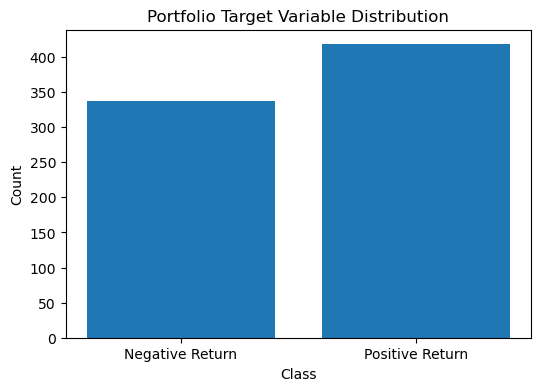

In [53]:
plt.figure(figsize=(6, 4))
plt.bar(target_counts.index, target_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Portfolio Target Variable Distribution')
plt.xticks([0, 1], ['Negative Return', 'Positive Return'])
plt.show()

In [54]:
# Check for significant imbalance
if class_ratio > 10:
    print("The data is imbalanced.")
else:
    print("The data is balanced.")

The data is balanced.


In [55]:
# Step 7: Dealing with Imbalanced Data (Using Class Weights)
target_variable = 'PortfolioReturn'  # Select the target variable for which we have class imbalance

In [56]:
# Assuming you have split the data into features (X) and target variable (y)
X_train, X_test = train_data.drop(target_variable, axis=1), test_data.drop(target_variable, axis=1)
y_train, y_test = train_data[target_variable], test_data[target_variable]

KeyError: "['PortfolioReturn'] not found in axis"